# EEG Alpha Decoding with CSP and LDA

This script evaluates the ability to decode task conditions from EEG alpha power by combining Common Spatial Patterns (CSP) for feature extraction with Linear Discriminant Analysis (LDA) for classification. It processes the data from multiple subjects, performs cross-validation, and reports classification accuracy.

> **Note:** Hyperparamter: n_comp; channels anterior to FC were omitted due to potential bridging

---

## **1. Data Loading and Preprocessing**
- **Data Import and Path Setup:**
  - Loads preprocessed EEG data (`X` for trials, channels, samples; `y` for labels; `fs` for sampling frequency) stored in `.npz` files.
  - Sets directory paths to locate data, derivatives, and directories for saving results and plots.

- **Channel Selection and Cleaning:**
  - Uses a predefined list of channels (`picks_hubner`).
  - For each subject, removes channels identified as noisy (via `subjects_channel_reject`).
  - Selects specific channels used for decoding (e.g., frontal, central, parietal, occipital regions).

- **Filtering and Artifact Removal:**
  - Applies a bandpass filter (8–12 Hz) using a Butterworth filter (via `bandpass_filter`) to isolate the alpha band.
  - Removes edge artifacts by cropping the filtered signal (discarding the first and last 120 samples).

- **Feature Extraction with Hilbert Transform:**
  - Computes the log-transformed mean amplitude using the Hilbert transform (via `compute_average_hilbert_amplitude`), providing a measure of alpha power per trial and channel.

---

## **2. Decoding Pipeline with CSP and LDA**
- **Common Spatial Patterns (CSP):**
  - Initializes a CSP object to derive spatial filters that maximize variance differences between the conditions.
  - Projects the preprocessed data into a CSP space (using a specified number of components) to enhance features relevant for decoding.

- **Classification with LDA:**
  - Initializes an LDA classifier with regularization provided by the Ledoit-Wolf covariance estimator.
  - Uses the CSP-transformed data with computed log-Hilbert amplitude as features for the LDA classifier.

- **Cross-Validation:**
  - Implements a 4-fold cross-validation scheme:
    - Splits the data into training and test sets.
    - Applies CSP and extracts features on the training set; fits LDA on these features.
    - Applies the same transformations to the test set and computes classification accuracy.
  - Computes mean accuracy and standard error for each subject over all folds.

---

## **3. Results Aggregation and Saving**
- **Per-Subject Results:**
  - For each subject, the script stores the mean decoding accuracy and the corresponding standard error from the cross-validation.
  
- **Group-Level Summary:**
  - Aggregates results across subjects, calculates overall mean accuracy and standard error, and prints these summary statistics.
  
- **Output Storage:**
  - Saves the results (subject ID, accuracy, and standard error) as a structured NumPy array in the designated results directory.

---

## **Purpose and Applications**
- **Objective:** 

  - To assess the effect of computing the alpha band feature vector from virtual channels as craeted by CSP as opposed to using a sub-set of physical channels.




In [1]:
import os
import numpy as np
from scipy.signal import butter, sosfilt, hilbert
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.covariance import LedoitWolf
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from os.path import join
import sys
import mne

mne.set_log_level('warning')

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")
features_dir = join(alpha_dir, "plots", "features")

In [2]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Apply a bandpass filter to the data.
    """
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data, axis=-1)
def compute_average_hilbert_amplitude(data):
    """
    Compute log-mean amplitude using Hilbert transform.
    """
    analytic = hilbert(data, axis=2)
    amplitude = np.abs(analytic)
    mean_amplitude = amplitude.mean(axis=2)
    return np.log(mean_amplitude)


In [3]:
# List of subjects and channels
subjects = [
    "VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih",
    "VPpdii", "VPpdij", "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip",
    "VPpdiq", "VPpdir", "VPpdis", "VPpdit", "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix",
    "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"
    ]
channel_dict = {
    'A1': 'Fp1', 'A2': 'AF7', 'A3': 'AF3', 'A4': 'F1', 'A5': 'F3', 'A6': 'F5', 'A7': 'F7', 'A8': 'FT7',
    'A9': 'FC5', 'A10': 'FC3', 'A11': 'FC1', 'A12': 'C1', 'A13': 'C3', 'A14': 'C5', 'A15': 'T7', 'A16': 'TP7',
    'A17': 'CP5', 'A18': 'CP3', 'A19': 'CP1', 'A20': 'P1', 'A21': 'P3', 'A22': 'P5', 'A23': 'P7', 'A24': 'P9',
    'A25': 'PO7', 'A26': 'PO3', 'A27': 'O1', 'A28': 'Iz', 'A29': 'Oz', 'A30': 'POz', 'A31': 'Pz', 'A32': 'CPz',
    'B1': 'Fpz', 'B2': 'Fp2', 'B3': 'AF8', 'B4': 'AF4', 'B5': 'AFz', 'B6': 'Fz', 'B7': 'F2', 'B8': 'F4',
    'B9': 'F6', 'B10': 'F8', 'B11': 'FT8', 'B12': 'FC6', 'B13': 'FC4', 'B14': 'FC2', 'B15': 'FCz', 'B16': 'Cz',
    'B17': 'C2', 'B18': 'C4', 'B19': 'C6', 'B20': 'T8', 'B21': 'TP8', 'B22': 'CP6', 'B23': 'CP4', 'B24': 'CP2',
    'B25': 'P2', 'B26': 'P4', 'B27': 'P6', 'B28': 'P8', 'B29': 'P10', 'B30': 'PO8', 'B31': 'PO4', 'B32': 'O2'
}
picks_hubner = [*channel_dict.values()]
subjects_channel_reject = {'VPpdia': ['POz', 'P2'],
                            'VPpdib': ['P2', 'FC1', 'CP2'],
                            'VPpdic': ['P2'], 
                            'VPpdid': ['P2'], 'VPpdie': ['P2'], 
                            'VPpdif': ['P2', 'POz'], 'VPpdig': ['P2'], 
                            'VPpdih': ['P2', 'C3'], 
                            'VPpdii': ['P2'], 
                            'VPpdij': ['P2', 'P10'], 
                            'VPpdik': ['P2'], 
                            'VPpdil': ['P2'], 
                            'VPpdim': [], 'VPpdin': ['P2', 'POz'], 
                            'VPpdio': [], 'VPpdip': [], 'VPpdiq': [], 
                            'VPpdir': [], 'VPpdis': [], 'VPpdit': [], 
                            'VPpdiu': ['P2'], 'VPpdiv': ['P2', 'PO4', 'P1', 'PO3'], 
                            'VPpdiw': ['P1', 'P3', 'POz', 'Pz', 'CPz'], 
                            'VPpdix': [], 'VPpdiy': [], 'VPpdiz': ['P1', 'PO3'], 
                            'VPpdiza': ['PO4'], 'VPpdizb': ['Fz'], 
                            'VPpdizc': ['P1', 'PO3', 'POz', 'Pz', 'P2', 'FC2']}


In [4]:
channel_dict = {
    'A1': 'Fp1', 'A2': 'AF7', 'A3': 'AF3', 'A4': 'F1', 'A5': 'F3', 'A6': 'F5', 'A7': 'F7', 'A8': 'FT7',
    'A9': 'FC5', 'A10': 'FC3', 'A11': 'FC1', 'A12': 'C1', 'A13': 'C3', 'A14': 'C5', 'A15': 'T7', 'A16': 'TP7',
    'A17': 'CP5', 'A18': 'CP3', 'A19': 'CP1', 'A20': 'P1', 'A21': 'P3', 'A22': 'P5', 'A23': 'P7', 'A24': 'P9',
    'A25': 'PO7', 'A26': 'PO3', 'A27': 'O1', 'A28': 'Iz', 'A29': 'Oz', 'A30': 'POz', 'A31': 'Pz', 'A32': 'CPz',
    'B1': 'Fpz', 'B2': 'Fp2', 'B3': 'AF8', 'B4': 'AF4', 'B5': 'AFz', 'B6': 'Fz', 'B7': 'F2', 'B8': 'F4',
    'B9': 'F6', 'B10': 'F8', 'B11': 'FT8', 'B12': 'FC6', 'B13': 'FC4', 'B14': 'FC2', 'B15': 'FCz', 'B16': 'Cz',
    'B17': 'C2', 'B18': 'C4', 'B19': 'C6', 'B20': 'T8', 'B21': 'TP8', 'B22': 'CP6', 'B23': 'CP4', 'B24': 'CP2',
    'B25': 'P2', 'B26': 'P4', 'B27': 'P6', 'B28': 'P8', 'B29': 'P10', 'B30': 'PO8', 'B31': 'PO4', 'B32': 'O2'
}
channels = [*channel_dict.values()]

In [6]:
task = "covert"
# Number of CSP components for feature extraction
n_comp = 6
bp_low  = 8
bp_high = 13
# Initialize results storage
results = []

# Loop through subjects
for subject in subjects:
    print(f"processing subj {subject}..")
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "alpha", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_alpha_64_ica.npz")
    # Check if file exists
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        continue
    
    # Clean channels
    picks_clean = channels.copy()
    
    # Adapt indexing for rejected channels
    if subject in subjects_channel_reject:
        # Get the channels to reject for this subject
        channels_to_reject = subjects_channel_reject[subject]
        # Remove all channels from picks_clean
        for channel in channels_to_reject:
            if channel in picks_clean:
                picks_clean.remove(channel)
    
    # Load data
    npz_data = np.load(file_path)
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels: trials
    fs = npz_data['fs']  # Sampling frequency
    fs = fs.flatten()[0]   # turn array to integer

    selected_indices = [picks_clean.index(ch) for ch in channels if ch in picks_clean]

    X = X[:, selected_indices, :]  # Crop to selected channels

    X = bandpass_filter(X, bp_low, bp_high, fs=fs)  # Bandpass filter for alpha band
    X = X[:, :, 120:-120]  # Remove edge artifacts
 
    # Initialize CSP and LDA, try reg=0.01 needed if this throws rank-defficiancy error 
    
    csp = CSP(n_components=n_comp, log=None, reg = 0.01, transform_into='csp_space')
    lda = LDA(solver="lsqr", covariance_estimator=LedoitWolf())

    # Cross-validation
    fold_accuracies = []
    n_folds = 4
    n_trials = X.shape[0] // n_folds
    folds = np.repeat(np.arange(n_folds), n_trials)

    for i_fold in range(n_folds):
        # Train-test split
        X_trn, y_trn = X[folds != i_fold], y[folds != i_fold]
        X_tst, y_tst = X[folds == i_fold], y[folds == i_fold]

        # CSP and LDA
        csp.fit(X_trn, y_trn)
        X_trn_csp = compute_average_hilbert_amplitude(csp.transform(X_trn))
        lda.fit(X_trn_csp, y_trn)

        X_tst_csp = compute_average_hilbert_amplitude(csp.transform(X_tst))
        # Predict and compute accuracy
        y_pred = lda.predict(X_tst_csp)
        accuracy = accuracy_score(y_tst, y_pred)
        fold_accuracies.append(accuracy)

    # Compute subject-level results
    accuracy = np.round(np.mean(fold_accuracies), 2)
    se = np.round(np.std(fold_accuracies) / np.sqrt(n_folds), 2)
    results.append((subject, accuracy, se))

# Convert results to a structured numpy array
results_array = np.array(
    results, dtype=[('subject', 'U10'), ('accuracy', 'f4'), ('standard_error', 'f4')]
)

# Save results

if not os.path.exists(decoding_results_dir):
        os.makedirs(decoding_results_dir)
results_save_path = join(decoding_results_dir, f"{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.npy")     
np.save(results_save_path, results_array)


# Overall results
overall_accuracy = np.round(results_array['accuracy'].mean(), 2)
overall_se = np.round(results_array['standard_error'].mean(), 2)
print(f"Overall LDA accuracy with CSP: {overall_accuracy:.2f} ± {overall_se:.2f}")


processing subj VPpdia..
processing subj VPpdib..
processing subj VPpdic..
processing subj VPpdid..
processing subj VPpdie..
processing subj VPpdif..
processing subj VPpdig..
processing subj VPpdih..
processing subj VPpdii..
processing subj VPpdij..
processing subj VPpdik..
processing subj VPpdil..
processing subj VPpdim..
processing subj VPpdin..
processing subj VPpdio..
processing subj VPpdip..
processing subj VPpdiq..
processing subj VPpdir..
processing subj VPpdis..
processing subj VPpdit..
processing subj VPpdiu..
processing subj VPpdiv..
processing subj VPpdiw..
processing subj VPpdix..
processing subj VPpdiy..
processing subj VPpdiz..
processing subj VPpdiza..
processing subj VPpdizb..
processing subj VPpdizc..
Overall LDA accuracy with CSP: 0.89 ± 0.03


### Plot performance

Overall Mean Accuracy with 6-CSP channels: 0.89 ± 0.03 


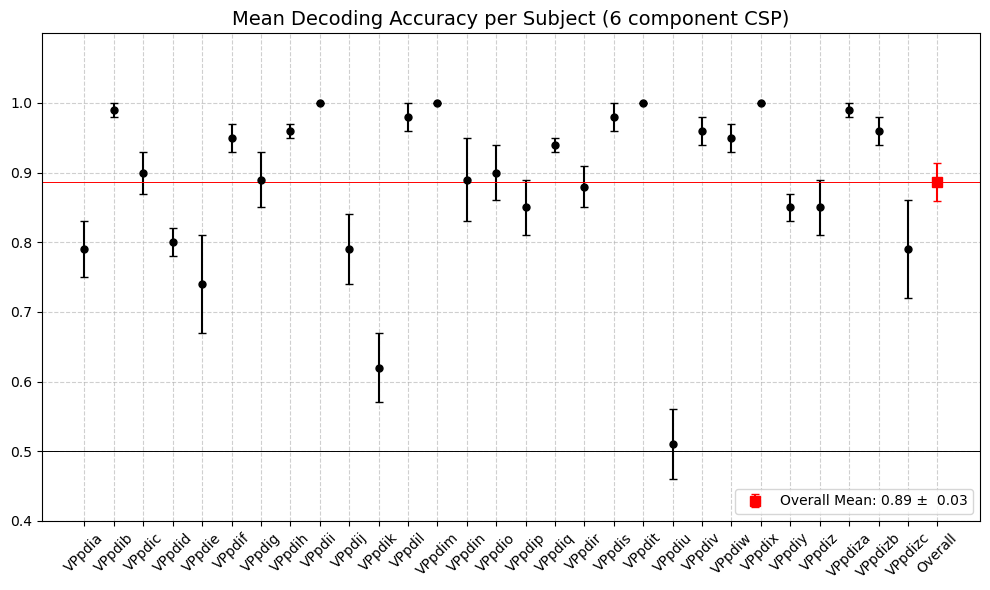

In [13]:
import matplotlib.pyplot as plt

# Extract relevant fields
subject_accuracies = results_array['accuracy']
subject_ses = results_array['standard_error']
subjects = results_array['subject']

# Compute overall mean accuracy and SE
overall_mean_accuracy = np.mean(subject_accuracies)
overall_se = np.mean(subject_ses)

# Plot individual subject accuracies with SE as error bars
plt.figure(figsize=(10, 6))
plt.errorbar(
    x=range(1, len(subject_accuracies) + 1),  # Subject indices
    y=subject_accuracies,  # Subject accuracies
    yerr=subject_ses,  # Standard errors
    fmt='o',
    color='k',
    ecolor='k',
    capsize=3,
    linestyle='None',
    markersize=5,
    label=''
)

# Add overall mean accuracy and SE as a separate point
plt.errorbar(
    x=[len(subject_accuracies) + 1],  
    y=[overall_mean_accuracy],
    yerr=[overall_se],
    fmt='s',
    color='r',
    ecolor='r',
    capsize=3,
    markersize=7,
    label=f'Overall Mean: {overall_mean_accuracy:.2f} ± {overall_se: .2f}'
)

# Customize plot
plt.title(f'Mean Decoding Accuracy per Subject ({n_comp} component CSP)', fontsize=14)
plt.xticks(
    ticks=range(1, len(subject_accuracies) + 2),  # Subject indices + "Overall"
    labels=list(subjects) + ['Overall'],  # Subject labels + "Overall"
    rotation=45,
    fontsize=10
)
plt.yticks(np.linspace(0, 1, 11))  # Y-axis ticks from 0 to 1 in 0.1 increments
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim([0.4, 1.1])  # Y-axis range
plt.axhline(y=0.5, color='k', linestyle='-', linewidth=0.7, label='')  # Chance level
plt.axhline(y=overall_mean_accuracy, color='r', linestyle='-', linewidth=0.7)  # Overall mean line

# Add legend
plt.legend(loc='lower right', fontsize=10)

# Save or show the plot
plt.tight_layout()

plots_dir = join(alpha_dir, "plots")
os.makedirs(os.path.dirname(plots_dir), exist_ok=True)

plt.savefig(join(plots_dir, f"{task}_alpha_lda_{n_comp}-comp_CSP_results.png"), dpi=300) 
plt.savefig(join(plots_dir, f"{task}_alpha_lda_{n_comp}-comp_CSP_results.svg"), dpi=300)  

plt.plot()

print(f"Overall Mean Accuracy with {n_comp}-CSP channels: {overall_mean_accuracy:.2f} ± {overall_se:.2f} ")

In [ ]:
X.shape

(80, 58, 2400)